In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt

In [4]:
# 加载数据
data = pd.read_csv('../input/b05testfeature/B0005.csv')

# 提取特征和目标变量
X = data[['HF1', 'HF2', 'HF3', 'HF4', 'HF5']]
y = data['capacity']
cycles = data['cycle']  # 提取循环次数

# 分割数据集，随机分配60%数据用于训练，40%数据用于测试
X_train, X_test, y_train, y_test, cycles_train, cycles_test = train_test_split(X, y, cycles, test_size=0.4, random_state=365)

# 定义XGBoost模型的超参数空间
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 6),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

In [5]:
def objective(params):
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
}

print(f"Best Parameters: {best_params}")

100%|██████████| 200/200 [01:53<00:00,  1.77trial/s, best loss: 0.00010612208132227191]
Best Parameters: {'n_estimators': 444, 'learning_rate': 0.13997452027403756, 'max_depth': 5, 'min_child_weight': 2.7094551587567635, 'subsample': 0.6961046216639045, 'colsample_bytree': 0.560448833370879}


In [7]:
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')

Train RMSE: 0.0006565531497736539
Train R2: 0.9999886056599477
Test RMSE: 0.010490658250061444
Test R2: 0.9965943144691004


In [8]:
cycles_all = pd.concat([cycles_train, cycles_test], axis=0)
y_true_all = pd.concat([y_train, y_test], axis=0)
y_pred_all = pd.concat([pd.Series(y_train_pred, index=cycles_train.index), pd.Series(y_test_pred, index=cycles_test.index)], axis=0)

sorted_index = cycles_all.argsort()
cycles_sorted = cycles_all.iloc[sorted_index]
y_true_sorted = y_true_all.iloc[sorted_index]
y_pred_sorted = y_pred_all.iloc[sorted_index]

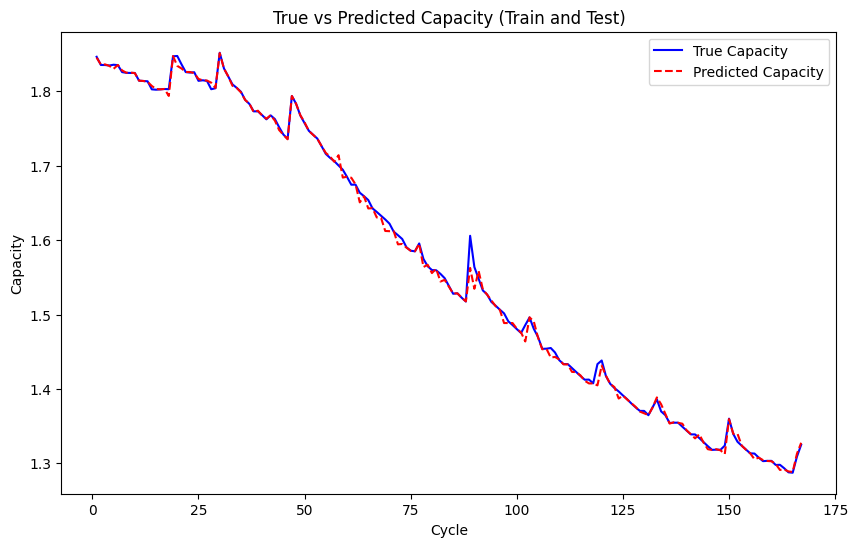

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(cycles_sorted, y_true_sorted, color='blue', label='True Capacity')
plt.plot(cycles_sorted, y_pred_sorted, color='red', linestyle='--', label='Predicted Capacity')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.title('True vs Predicted Capacity (Train and Test)')
plt.show()